In [1]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import pandas as pd
import os
import sys
import time
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable


#%matplotlib qt 


In [2]:
file_name_cube = '/Users/eckhartspalding/Documents/git.repos/life_detectors/parameter_sweep/junk/s2n_sweep_n00026020.fits'

In [3]:
# read in the FITS file
with fits.open(file_name_cube) as hdul:
    data_cube = hdul[0].data
    header = hdul[0].header
    # [0]: S/N values
    # [1]: wavelength bin centers
    # [2]: wavelength bin widths
    # [3]: dark current values




In [4]:
# print the FITS header, one line per keyword
for keyword in hdul[0].header.keys():
    print(f"{keyword}: {hdul[0].header[keyword]}")


SIMPLE: True
BITPIX: -64
NAXIS: 3
NAXIS1: 151
NAXIS2: 1400
NAXIS3: 4
EXTEND: True
telescope.collecting_area: 25.0
telescope.plate_scale: 0.1
telescope.throughput: 0.8
telescope.eta_t: 0.05
telescope.single_mirror_diameter: 2.0
target.distance: 10.0
target.pl_temp: 200.0
target.rad_star: 1.0
target.t_star: 5778.0
target.l_star: 1.0
target.rad_planet: 1.0
target.a_albedo: 0.22
target.t_eff_zodiacal: 265.0
target.z_exozodiacal: 1
target.tau_opt_zodiacal: 4e-8
target.planet_source: file
nulling.null: True
nulling.nulling_factor: 0.00001
detector.read_noise: 6
detector.dark_current: 0.0, 70., 0.05
detector.gain: 4.5
detector.quantum_efficiency: 0.1
detector.spec_res: 50
detector.photons_to_e: 1.0
detector.size: 1024
detector.pitch_pix: 25
detector.pix_per_wavel_bin: 2.2
detector.pix_spectral_width: 3
observation.integration_time: 100
observation.n_int: 26020
observation.lambda_rel_lon_los: 135
observation.beta_lat_los: 45
wavelength_range.min: 1.0
wavelength_range.max: 20.0
wavelength_range

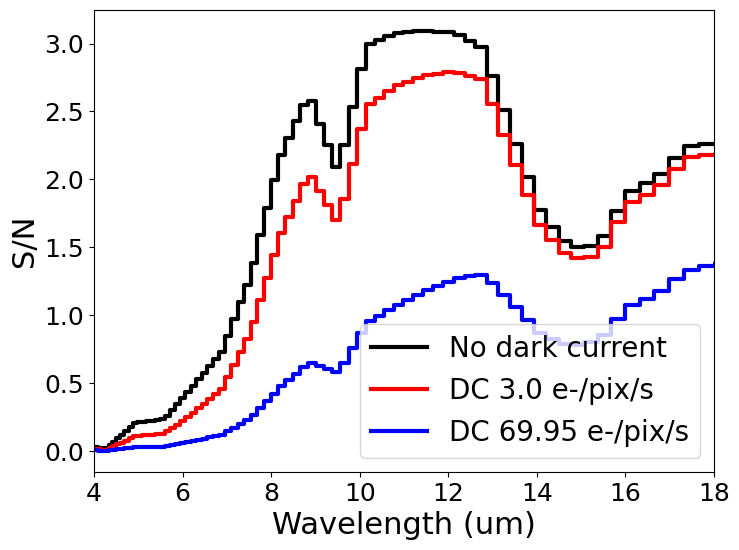

In [ ]:
plt.rcParams.update({'font.size': 20, 'xtick.labelsize': 18, 'ytick.labelsize': 18, 'axes.labelsize': 22, 'axes.titlesize': 22})

#max_int_time = 5184000 # total integration time of the longest observation in the cube, in seconds
n_int_this = 100

# indices of choices of DC values to plot in comparison with zero DC
n_dc_1 = 60
n_dc_2 = 400

# the actual DC value
dc_1 = np.median(data_cube[3,n_dc_1,:])
dc_2 = np.median(data_cube[3,n_dc_2,:])


plt.figure(figsize=(8, 6))
#plt.title('N_INT = '+str(n_int_this))
plt.step(data_cube[1,0,:], data_cube[0,0,:], where='mid', color='black', linewidth=3, label='No dark current')
plt.step(data_cube[1,n_dc_1,:], data_cube[0,n_dc_1,:], where='mid', color='red', linewidth=3, label='DC '+str(dc_1) + ' e-/pix/s')
plt.step(data_cube[1,n_dc_2,:], data_cube[0,n_dc_2,:], where='mid', color='blue', linewidth=3, label='DC '+str(dc_2) + ' e-/pix/s')
plt.xlim([4.0, 18.])
#plt.ylim([1e-3, 1e0.5])
plt.ylabel('S/N')
#plt.yscale('log')
plt.xlabel('Wavelength (um)')
plt.legend()
file_name_s2n_plot = '/Users/eckhartspalding/Downloads/junk2_s2n_w_diff_dc.png'
plt.savefig(file_name_s2n_plot)
print(f"Saved S/N plot to {file_name_s2n_plot}")
#plt.show()

[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.5   1.25  2.45  4.35  6.8   9.8  13.2  16.3
 19.95 24.1  26.6  24.5  22.25 19.9  25.85 37.   50.7  63.05 69.1  69.95
 69.95 69.95 69.95 69.95 69.95 69.95 69.95 69.95 69.95 69.95 69.95 69.95
 64.   47.55 40.25 34.15 32.65 34.85 43.1  64.05 69.95 69.95 69.95 69.95
 69.95 69.95 69.95 69.95 69.95 69.95 69.95]
[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    

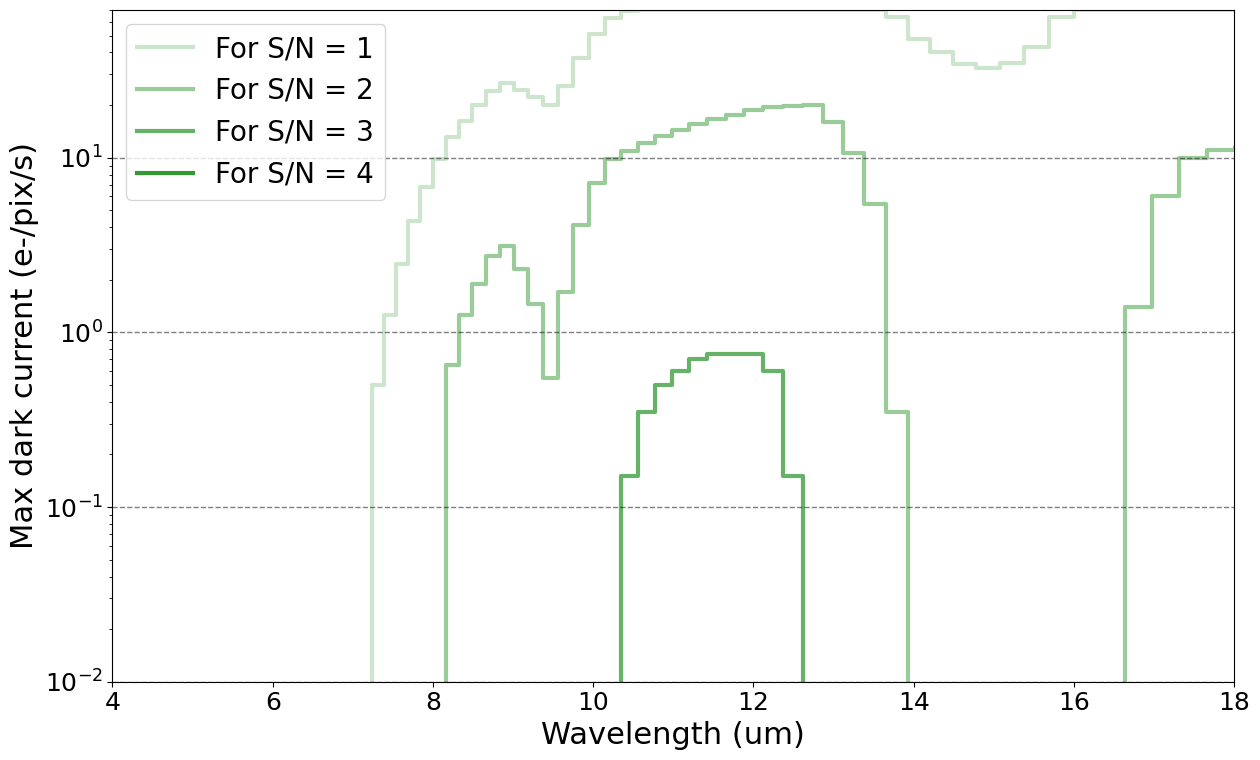

In [ ]:
# plot acceptable DC: for S/N of P, how much DC can we have?

s2n_acceptable = [1,2,3,4]

# loop down the rows of S/N (i.e., for descending dark current)
# as soon as a given column rises from below the value of s2n_acceptable to above it, 
# fill the corresponding element in an array (which has the length of the wavelength bins, i.e., x) with that DC value

plt.figure(figsize=(13, 8))

for s2n_acceptable_this in s2n_acceptable:
    # for each S/N level, find the acceptable DC

    resids_from_acceptable_s2n = np.subtract(data_cube[0,:,:],s2n_acceptable_this)

    # in each column, find the location of the minimum value
    # Find the index (row, i.e., DC value) for each column (wavelength) where the S/N residual from the target is minimal across the DC axis
    arg_min_resid_in_each_column = np.argmin(np.abs(resids_from_acceptable_s2n), axis=0)  # shape: (number of wavelength bins,)

    # find the DC corresponding to each argument
    acceptable_dc_at_each_wavelength = np.array([
        data_cube[3, dc_idx, col_idx]
        for col_idx, dc_idx in enumerate(arg_min_resid_in_each_column)
    ])

    print(acceptable_dc_at_each_wavelength)

    #plt.title('N_INT = '+str(n_int_this))
    plt.step(data_cube[1,0,:], acceptable_dc_at_each_wavelength, where='mid', color='green', linewidth=3, label='For S/N = '+str(s2n_acceptable_this), alpha=2 * int(s2n_acceptable_this) / 10)
#plt.step(data_cube[1,n_dc_1,:], data_cube[0,n_dc_1,:], where='mid', color='red', linewidth=3, label='DC '+str(dc_1) + ' e-/pix/s')
#plt.step(data_cube[1,n_dc_2,:], data_cube[0,n_dc_2,:], where='mid', color='blue', linewidth=3, label='DC '+str(dc_2) + ' e-/pix/s')
# Plot thin dashed lines at each octave (10^0, 10^1, 10^2, etc.)
octaves = [10**i for i in range(-2, 2)]  # from 0.01 to 100 (within the ylim used)
for oct in octaves:
    plt.axhline(oct, color='k', linestyle='--', linewidth=1, alpha=0.5)

plt.xlim([4.0, 18.])
plt.ylim([1e-2, 70])
plt.ylabel('Max dark current (e-/pix/s)')
plt.yscale('log')
plt.xlabel('Wavelength (um)')
plt.legend()
plt.tight_layout()
file_name_acceptable_dc_plot = '/Users/eckhartspalding/Downloads/junk3_acceptable_dc_plot.png'
plt.savefig(file_name_acceptable_dc_plot)
print(f"Saved acceptable DC plot to {file_name_acceptable_dc_plot}")
#plt.show()


In [43]:
plt.clf()
plt.figure(figsize=(2, 28))
plt.imshow(resids_from_acceptable_s2n, origin='lower')
# Make y-ticks based on data_cube[3,:,0]
y_ticks = data_cube[3,:,0]
# Only plot a tick at whole numbers
whole_number_indices = [i for i, y in enumerate(y_ticks) if np.isclose(y, np.round(y))]  # where y is an integer
plt.yticks(
    ticks=whole_number_indices,
    labels=[f"{int(round(y_ticks[i]))}" for i in whole_number_indices]
)

plt.contour(resids_from_acceptable_s2n, levels=[0], colors='red', origin='lower')

#plt.colorbar()
plt.show()

In [13]:
range(data_cube.shape[1])

range(0, 1400)

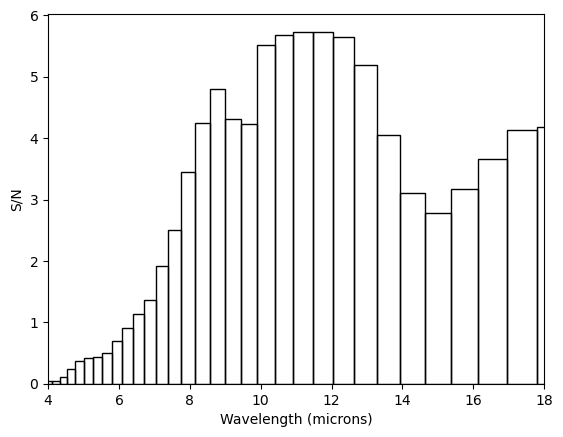

In [5]:
plt.bar(data_cube[1,0,:], data_cube[0,0,:], width=data_cube[2,0,:], 
        fill=False, edgecolor='black', align='center')
plt.xlim([4.0, 18.])
plt.ylabel('S/N')
#plt.yscale('log')
plt.xlabel('Wavelength (microns)')
plt.savefig('junk1.png')

In [10]:
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                   61                                                  
NAXIS2  =                 1400                                                  
NAXIS3  =                    4                                                  
HIERARCH telescope.collecting_area = '25.0    '                                 
HIERARCH telescope.plate_scale = '0.1     '                                     
HIERARCH telescope.throughput = '0.8     '                                      
HIERARCH telescope.eta_t = '0.05    '                                           
HIERARCH telescope.single_mirror_diameter = '2.0     '                          
HIERARCH target.distance = '10.0    '                                           
HIERARCH target.pl_temp = '2